In [1]:
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.utils import plot_model

from tensorflow.keras.layers import Input,LSTM,Embedding,Dense,Concatenate,Attention
from nltk.stem import WordNetLemmatizer 
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [2]:
rdata = pd.read_csv("./Reviews.csv")

In [3]:
rdata

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if not better than resturants I have eaten at..My husband loved it..will find other recipes to use this in..
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,"I'm disappointed with the flavor. The chocolate notes are especially weak. Milk thickens it but the flavor still disappoints. This was worth a try but I'll never buy again. I will use what's left,..."
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 of those in one training session. I tried to train our dog with ""Ceaser dog treats"", it just made our puppy hyper. If you compare the ingredients, y..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rewarding your dog for being good while grooming. Lower in calories and loved by all the doggies. Sweet potatoes seem to be their favorite Wet Noses tr...


In [4]:
rdata.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [5]:
rdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [6]:
rdata.drop_duplicates(subset=['Text'],inplace=True)  #dropping duplicates
rdata.dropna(axis=0,inplace=True)   #dropping na

In [7]:
rdata = rdata[['Summary', 'Text']]
print(rdata.shape)
rdata.head()

(393565, 2)


,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


In [8]:
rdata = rdata.dropna()
rdata = rdata.reset_index(drop=True)

In [9]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [10]:
rdata['Text'][:10]

0    I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1             Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
2    This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...
3    If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The fl...
4                                                               Great taffy at a great price.  There was a wide assortment of yummy taffy.  Delivery was very quick.  If your a taff

In [11]:
rdata['Summary'][:10]

0                            Good Quality Dog Food
1                                Not as Advertised
2                            "Delight" says it all
3                                   Cough Medicine
4                                      Great taffy
5                                       Nice Taffy
6    Great!  Just as good as the expensive brands!
7                           Wonderful, tasty taffy
8                                       Yay Barley
9                                 Healthy Dog Food
Name: Summary, dtype: object

In [12]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [lemmatizer.lemmatize(w) for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in rdata['Text']:
    cleaned_text.append(text_cleaner(t))

In [13]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in rdata['Summary']:
    cleaned_summary.append(summary_cleaner(t))

rdata['cleaned_text']=cleaned_text
rdata['cleaned_summary']=cleaned_summary
rdata['cleaned_summary'].replace('', np.nan, inplace=True)
rdata.dropna(axis=0,inplace=True)

In [14]:
rdata['cleaned_text'][:10]

0                                          bought several vitality canned dog food product found good quality product look like stew processed meat smell better labrador finicky appreciates product better
1                                                                        product arrived labeled jumbo salted peanut peanut actually small sized unsalted sure error vendor intended represent product jumbo
2    confection around century light pillowy citrus gelatin nut case filbert cut tiny square liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar s...
3                                                                                looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
4                                                                                                                        great taffy great price wide assortment yummy taffy deliver

In [15]:
rdata['cleaned_summary'][:10]

0                         good quality dog food 
1                             not as advertised 
2                           delight says it all 
3                                cough medicine 
4                                   great taffy 
5                                    nice taffy 
6    great just as good as the expensive brands 
7                         wonderful tasty taffy 
8                                    yay barley 
9                              healthy dog food 
Name: cleaned_summary, dtype: object

In [16]:
rdata['cleaned_summary'] = rdata['cleaned_summary'].apply(lambda x : 'sos '+ x + ' eos')

In [17]:
for i in range(5):
    print("Review:",rdata['cleaned_text'][i])
    print("Summary:",rdata['cleaned_summary'][i])
    print("\n")

Review: bought several vitality canned dog food product found good quality product look like stew processed meat smell better labrador finicky appreciates product better
Summary: sos good quality dog food  eos


Review: product arrived labeled jumbo salted peanut peanut actually small sized unsalted sure error vendor intended represent product jumbo
Summary: sos not as advertised  eos


Review: confection around century light pillowy citrus gelatin nut case filbert cut tiny square liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sister witch
Summary: sos delight says it all  eos


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: sos cough medicine  eos


Review: great taffy great price wide assortment yummy taffy delivery quick taffy lover deal
Summary: sos great taffy  

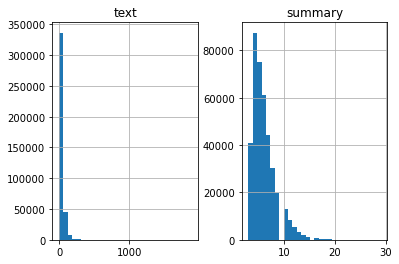

In [18]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in rdata['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in rdata['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [19]:
from statistics import mode
input_words = sorted(list(set(" ".join(list(rdata['cleaned_text'])))))
target_words = sorted(list(set(" ".join(list(rdata['cleaned_summary'])))))
num_in_words = len(input_words) #total number of input words
num_tr_words = len(target_words) #total number of target words
 
#get the length of the input and target texts which appears most often  
max_in_len = mode([len(i) for i in rdata['cleaned_text']])
max_tr_len = mode([len(i) for i in rdata['cleaned_summary']])
 
print("number of input words : ",num_in_words)
print("number of target words : ",num_tr_words)
print("maximum input length : ",max_in_len)
print("maximum target length : ",max_tr_len)

number of input words :  27
number of target words :  27
maximum input length :  91
maximum target length :  18


In [20]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(rdata['cleaned_text'],rdata['cleaned_summary'],test_size=0.2,random_state=0) 

In [21]:
in_tokenizer = Tokenizer()
in_tokenizer.fit_on_texts(x_train)
tr_tokenizer = Tokenizer()
tr_tokenizer.fit_on_texts(y_train)
 
#convert text into sequence of integers
#where the integer will be the index of that word
x_train= in_tokenizer.texts_to_sequences(x_train) 
y_train= tr_tokenizer.texts_to_sequences(y_train)

y_voc_size  =   len(tr_tokenizer.word_index) +1

x_voc_size  =   len(in_tokenizer.word_index) +1

In [22]:
en_in_data= pad_sequences(x_train,  maxlen=max_in_len, padding='post') 
dec_data= pad_sequences(y_train,  maxlen=max_tr_len, padding='post')
 
#decoder input data will not include the last word 
#i.e. 'eos' in decoder input data
dec_in_data = dec_data[:,:-1]
#decoder target data will be one time step ahead as it will not include
# the first word i.e 'sos'
dec_tr_data = dec_data.reshape(len(dec_data),max_tr_len,1)[:,1:]

In [23]:
len(dec_data[0])

18

In [24]:
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_in_len,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attention =Attention()
attn_out = attention([decoder_outputs,encoder_outputs])

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 91)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 91, 500)      50086000    ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 91, 500),    2002000     ['embedding[0][0]']              
                                 (None, 500),                                                     
                                 (None, 500)]                                                     
                                                                                              

In [25]:
len(en_in_data)

314577

In [ ]:
model.compile( 
    optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"] ) 
model.fit( 
    [en_in_data,dec_in_data],
    dec_tr_data, 
    batch_size=512, 
    epochs=1, 
    validation_split=0.1,
    )

 18/553 [..............................] - ETA: 9:30:45 - loss: 3.2005 - accuracy: 0.6725

In [ ]:
latent_dim=500
# #/content/gdrive/MyDrive/Text Summarizer/
# #load the model
# model = models.load_model("s2s")
 
#construct encoder model from the output of 6 layer i.e.last LSTM layer
en_outputs,state_h_enc,state_c_enc = model.layers[6].output
en_states=[state_h_enc,state_c_enc]
#add input and state from the layer.
en_model = Model(model.input[0],[en_outputs]+en_states)

In [ ]:
# decoder inference
#create Input object for hidden and cell state for decoder
#shape of layer with hidden or latent dimension
dec_state_input_h = Input(shape=(latent_dim,))
dec_state_input_c = Input(shape=(latent_dim,))
dec_hidden_state_input = Input(shape=(max_in_len,latent_dim))
 
# Get the embeddings and input layer from the model
dec_inputs = model.input[1]
dec_emb_layer = model.layers[5]
dec_lstm = model.layers[7]
dec_embedding= dec_emb_layer(dec_inputs)
 
#add input and initialize LSTM layer with encoder LSTM states.
dec_outputs2, state_h2, state_c2 = dec_lstm(dec_embedding, initial_state=[dec_state_input_h,dec_state_input_c])

In [ ]:
#Attention layer
attention = model.layers[8]
attn_out2 = attention([dec_outputs2,dec_hidden_state_input])
 
merge2 = Concatenate(axis=-1)([dec_outputs2, attn_out2])

In [ ]:
#Dense layer
dec_dense = model.layers[10]
dec_outputs2 = dec_dense(merge2)
 
# Finally define the Model Class
dec_model = Model(
[dec_inputs] + [dec_hidden_state_input,dec_state_input_h,dec_state_input_c],
[dec_outputs2] + [state_h2, state_c2])

In [ ]:
#create a dictionary with a key as index and value as words.
reverse_target_word_index = tr_tokenizer.index_word
reverse_source_word_index = in_tokenizer.index_word
target_word_index = tr_tokenizer.word_index
reverse_target_word_index[0]=' '
 
def decode_sequence(input_seq):
    #get the encoder output and states by passing the input sequence
    en_out, en_h, en_c= en_model.predict(input_seq)
 
    #target sequence with initial word as 'sos'
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_word_index['sos']
 
    #if the iteration reaches the end of text than it will be stop the iteration
    stop_condition = False
    #append every predicted word in decoded sentence
    decoded_sentence = ""
    while not stop_condition: 
        #get predicted output, hidden and cell state.
        output_words, dec_h, dec_c= dec_model.predict([target_seq] + [en_out,en_h, en_c])
        
        #get the index and from the dictionary get the word for that index.
        word_index = np.argmax(output_words[0, -1, :])
        text_word = reverse_target_word_index[word_index]
        decoded_sentence += text_word +" "

In [ ]:
# Exit condition: either hit max length
      # or find a stop word or last word.
      if text_word == "eos" or len(decoded_sentence) > max_tr_len:
        stop_condition = True
      #update target sequence to the current word index.
      target_seq = np.zeros((1, 1))
      target_seq[0, 0] = word_index
      en_h, en_c = dec_h, dec_c
  #return the decoded sentence
  return decoded_sentence

In [ ]:
inp_review = input("Enter : ")
print(“Review :”,inp_review)
inp_review = clean(inp_review,"inputs")
inp_review = ' '.join(inp_review)
inp_x= in_tokenizer.texts_to_sequences([inp_review]) 
inp_x= pad_sequences(inp_x,  maxlen=max_in_len, padding='post')
 
summary=decode_sequence(inp_x.reshape(1,max_in_len))
if 'eos' in summary :
  summary=summary.replace('eos','')
print("\nPredicted summary:",summary);print("\n")